## Stage X: Model Training

### 1. Objective

### 2. Approach

### 3. Implementation

In [56]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from src.visualization.plot_training import plot_training_history, plot_confusion_matrix, plot_validation_history

vocab_size = 20000

In [4]:
data_dir = os.path.join(os.getcwd(), '..', 'data/processed')
train_dataset = tf.data.Dataset.load(path=os.path.join(data_dir,'train_dataset'),)
test_dataset = tf.data.Dataset.load(path=os.path.join(data_dir,'test_dataset'))

print("Train dataset:", train_dataset)

Train dataset: <_LoadDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.int32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float64, name=None))>


Definition of a simple model with output embedding of 12 and a dense layer of 24

In [13]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,612 (939.89 KB)

 Trainable params: 240,612 (939.89 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the model

In [14]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

Defining epochs and training the model

In [15]:
num_epochs = 100
history_1 = model_1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)   

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.0510 - loss: 1.9134 - val_f1_score: 0.0878 - val_loss: 1.8382
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.1088 - loss: 1.6194 - val_f1_score: 0.1365 - val_loss: 1.4033
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2337 - loss: 1.2213 - val_f1_score: 0.2576 - val_loss: 1.0733
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2886 - loss: 0.9806 - val_f1_score: 0.2979 - val_loss: 0.9395
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3598 - loss: 0.8501 - val_f1_score: 0.3559 - val_loss: 0.8542
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4153 - loss: 0.7576 - val_f1_score: 0.4058 - val_loss: 0.7805
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4575 - loss: 0.6836 - val_f1_score: 0.4370 - val_loss: 0.7174
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4882 - loss: 0

Plot F1Score, loss vs validation loss and confusion matrix

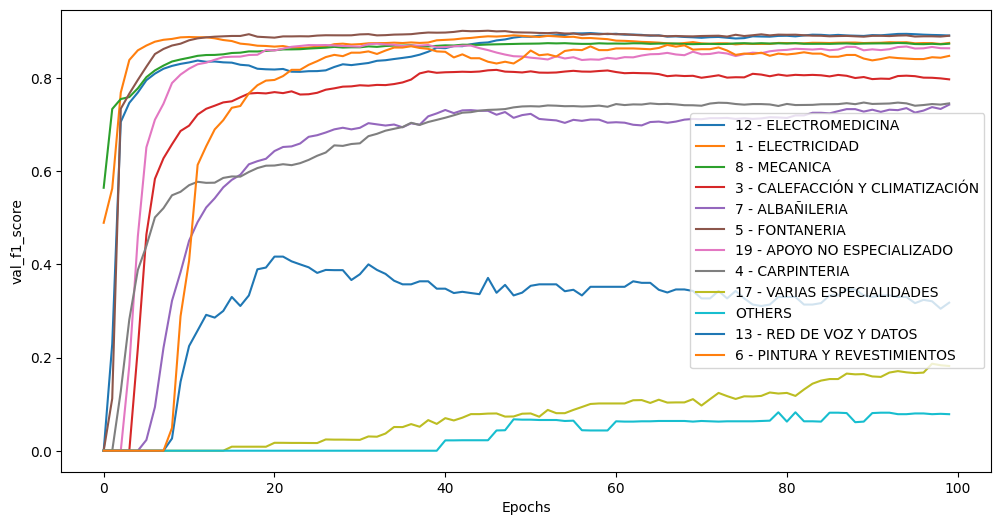

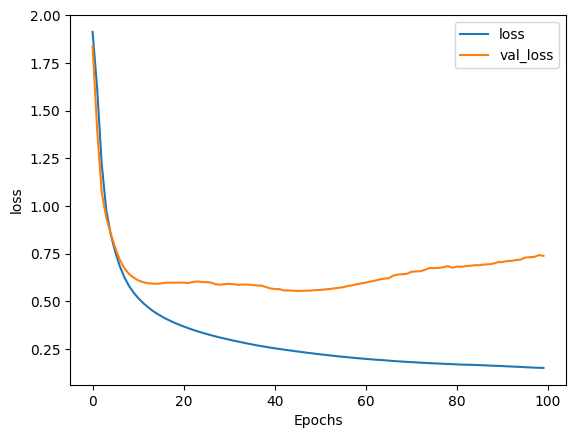

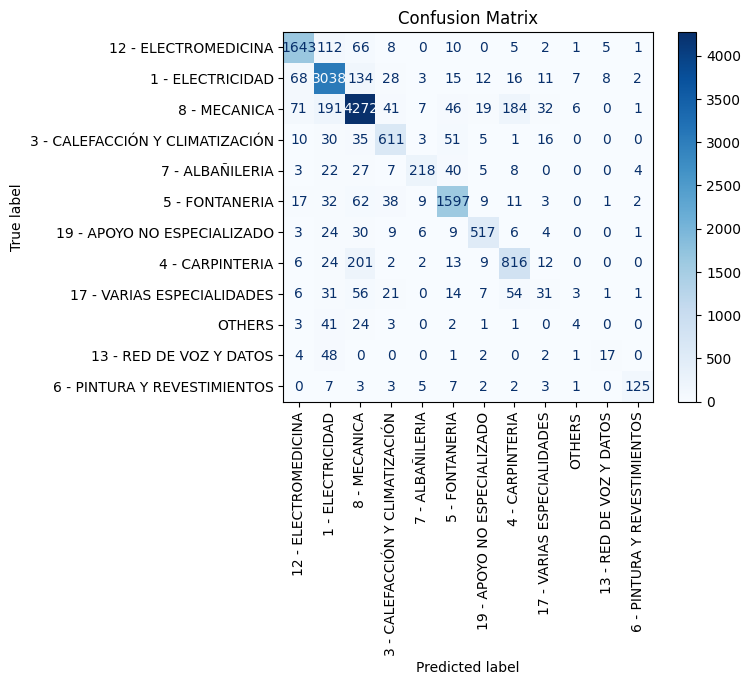

In [16]:
plot_validation_history(history_1, 'val_f1_score')
plot_training_history(history_1, 'loss')
plot_confusion_matrix(test_dataset, model_1)

After 100 epochs, looks like if we keep training it's gonna improve little by little, but because it's an imbalance dataset, "OTHERS"  and "17 - VARIAS ESPECIALIDADES" takes longer to start activating the layers. Also the loss in validation dataset is rapidly increasing. Let's change a little the approach by giving different weights to every category.

In [6]:
# Calculate weights for each class over the entire train_dataset
train_labels = pd.read_csv(os.path.join(os.getcwd(), '..',"data/processed","training_label.csv"))
total_class_counts = train_labels.value_counts()
print("Total class counts:", total_class_counts.values)
n_labels = total_class_counts.size
n_entries = total_class_counts.sum()
class_weights = {i: 1/total_class_counts.iloc[i] * (n_entries / n_labels) for i in range(n_labels)}
print("Class weights:", class_weights)

Total class counts: [19607 13332  7195  7129  4233  3039  2480  1370   915   733   356   304]
Class weights: {0: np.float64(0.2579563421227113), 1: np.float64(0.3793691869186919), 2: np.float64(0.7029534398888116), 3: np.float64(0.7094613550287558), 4: np.float64(1.1948381762343492), 5: np.float64(1.66428101349128), 6: np.float64(2.0394153225806453), 7: np.float64(3.691788321167883), 8: np.float64(5.527595628415301), 9: np.float64(6.900068212824011), 10: np.float64(14.207162921348313), 11: np.float64(16.637335526315788)}


This way categories with smaller examples have higher weights and these will cause the model to pay more attention to those under-represented classes.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,612 (939.89 KB)

 Trainable params: 240,612 (939.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.0399 - loss: 2.9613 - val_f1_score: 0.0606 - val_loss: 2.3860
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.1402 - loss: 2.5762 - val_f1_score: 0.2630 - val_loss: 1.7648
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2710 - loss: 2.0094 - val_f1_score: 0.2938 - val_loss: 1.4832
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3176 - loss: 1.6306 - val_f1_score: 0.3309 - val_loss: 1.2744
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3485 - loss: 1.3917 - val_f1_score: 0.3617 - val_loss: 1.1509
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3933 - loss: 1.2452 - val_f1_score: 0.4026 - val_loss: 1.0703
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4352 - loss: 1.1415 - val_f1_score: 0.4349 - val_loss: 1.0135
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4760 - loss: 1

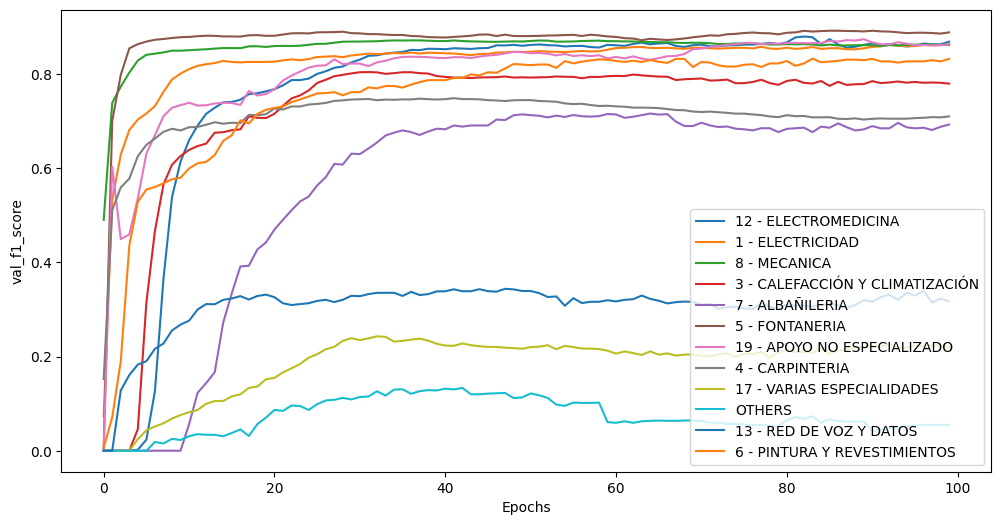

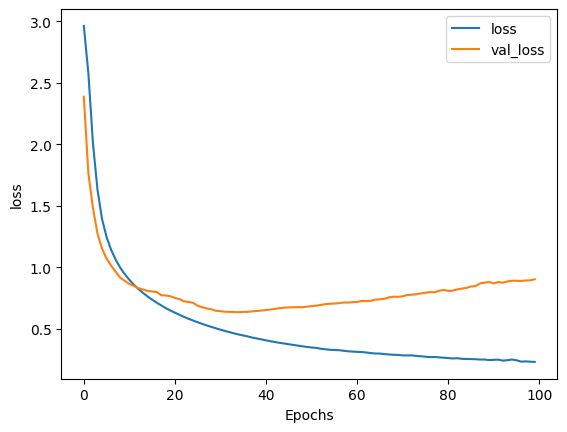

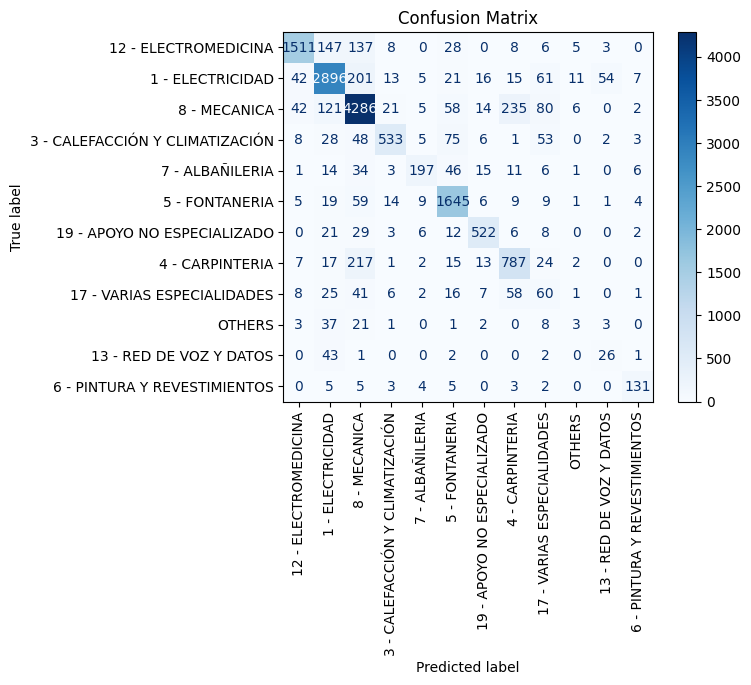

In [18]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_2.summary()

model_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)
num_epochs = 100
history_2 = model_2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    class_weight=class_weights,
    verbose=1
)

plot_validation_history(history_2, 'val_f1_score')
plot_training_history(history_2, 'loss')
plot_confusion_matrix(test_dataset, model_2)

Now the small labels play a bigger role in the improvement of the model sooner, but in the long run doesn't seams to improve the performance in the small label. Validation loss tend to increase at a slow peace. Let's keep exploring how the model can be improved.

Using Convolution layers

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 118, 6)         │           222 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 118, 6)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 6)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 24)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,690 (940.20 KB)

 Trainable params: 240,690 (940.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.2620 - loss: 2.1614 - val_f1_score: 0.4350 - val_loss: 1.3443
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4213 - loss: 1.5283 - val_f1_score: 0.5055 - val_loss: 1.1894
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4646 - loss: 1.3537 - val_f1_score: 0.5212 - val_loss: 1.1037
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.4818 - loss: 1.2522 - val_f1_score: 0.5227 - val_loss: 1.0613
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.4919 - loss: 1.1622 - val_f1_score: 0.5197 - val_loss: 1.0215
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4996 - loss: 1.0996 - val_f1_score: 0.5280 - val_loss: 0.9896
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.5163 - loss: 1.0464 - val_f1_score: 0.5398 - val_loss: 0.9605
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.5311 - loss: 1

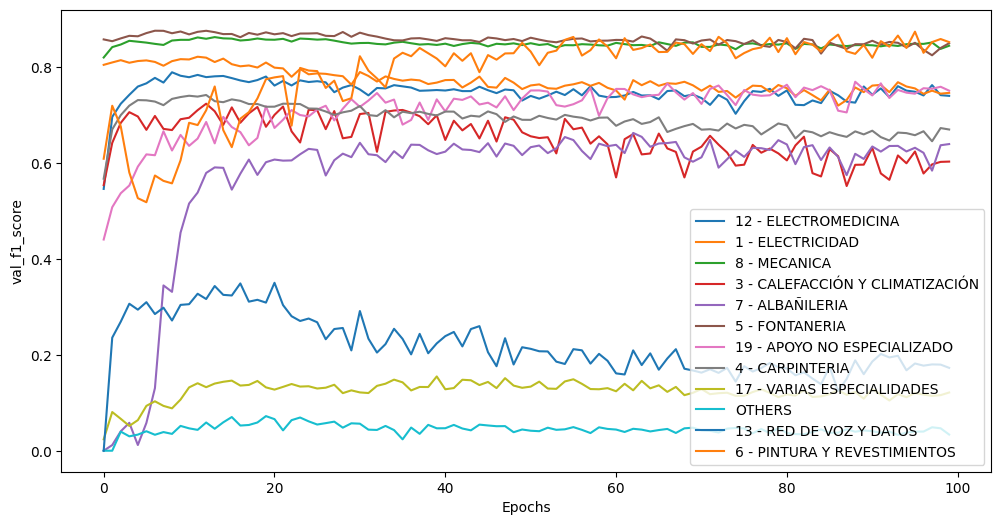

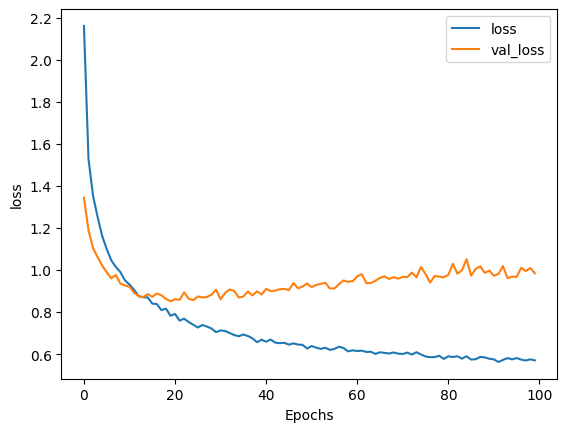

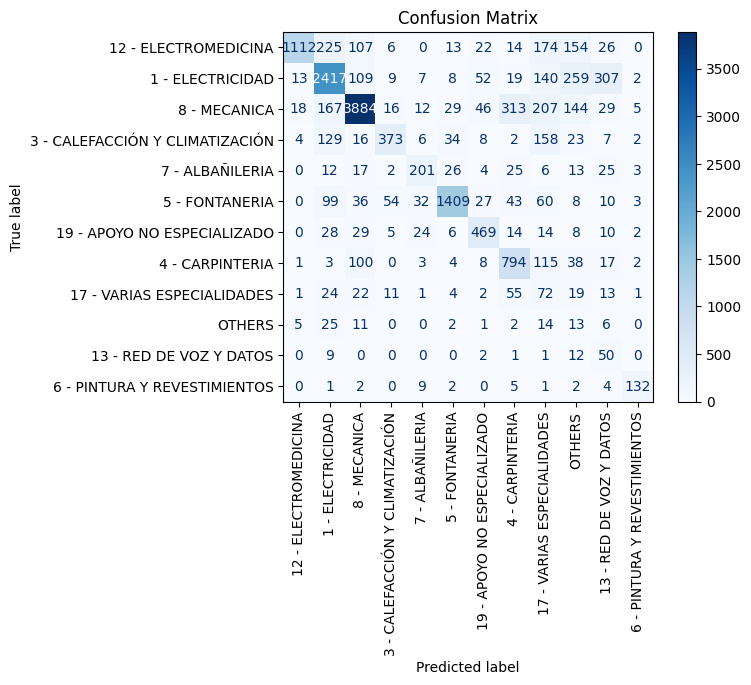

In [20]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.Conv1D(filters=6, kernel_size=3, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Adding dropout to reduce overfitting
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_3.summary()

model_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)
num_epochs = 100
history_3 = model_3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    class_weight=class_weights,
    verbose=1
)

plot_validation_history(history_3, 'val_f1_score')
plot_training_history(history_3, 'loss')
plot_confusion_matrix(test_dataset, model_3)

A convolution layer don't help to improve the model.

Let's try with RNN like LSTM

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 48)             │         7,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,692 (967.55 KB)

 Trainable params: 247,692 (967.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 44s 22ms/step - f1_score: 0.2169 - loss: 2.1269 - val_f1_score: 0.3384 - val_loss: 1.2000
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - f1_score: 0.3794 - loss: 1.2648 - val_f1_score: 0.4139 - val_loss: 0.9928
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - f1_score: 0.4846 - loss: 1.0323 - val_f1_score: 0.5215 - val_loss: 0.8752
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - f1_score: 0.5620 - loss: 0.8984 - val_f1_score: 0.5670 - val_loss: 0.7917
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - f1_score: 0.6062 - loss: 0.8183 - val_f1_score: 0.5723 - val_loss: 0.7877
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - f1_score: 0.6370 - loss: 0.7631 - val_f1_score: 0.6047 - val_loss: 0.7530
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - f1_score: 0.6678 - loss: 0.6751 - val_f1_score: 0.6196 - val_loss: 0.7526
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - f1_score: 

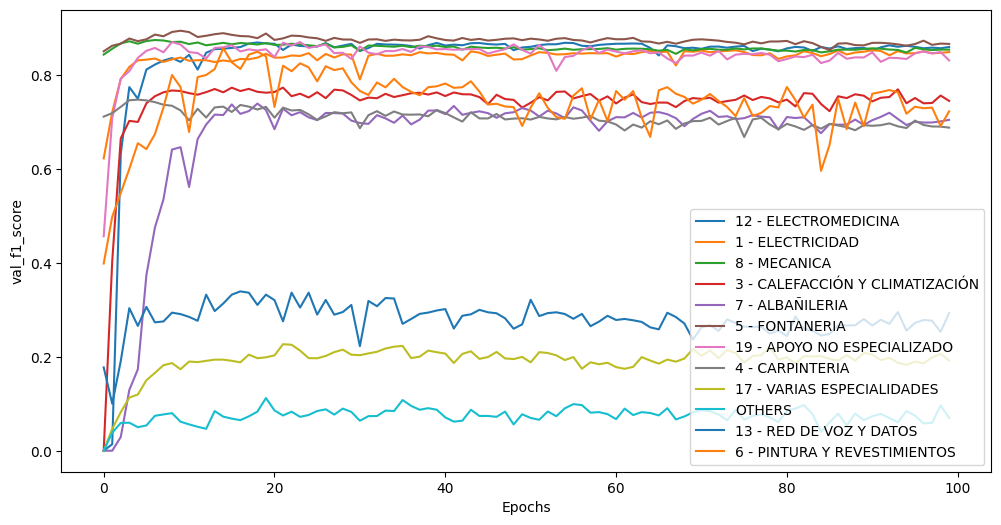

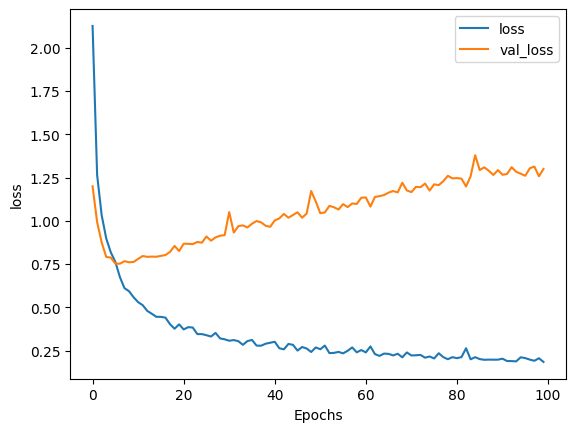

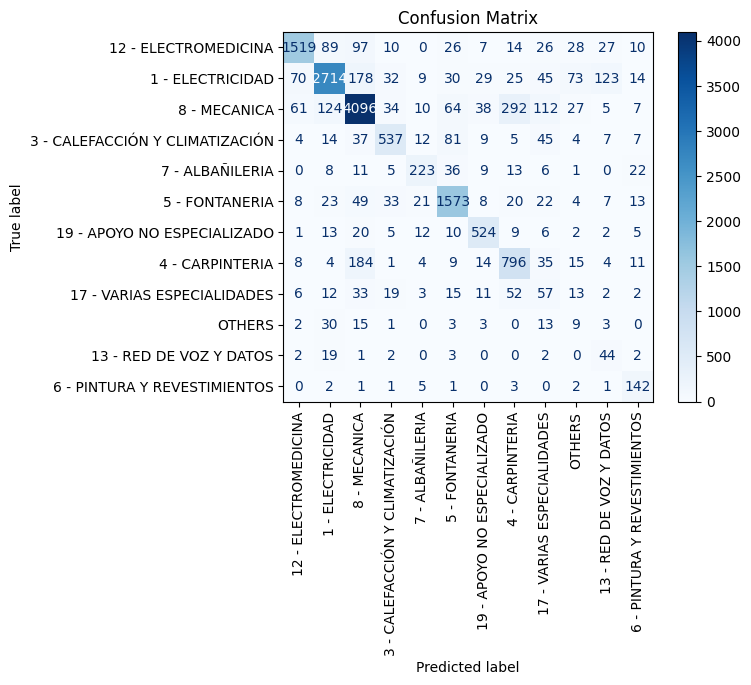

In [7]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24)),
    tf.keras.layers.Dropout(0.5), # Adding dropout to reduce overfitting
    tf.keras.layers.Dense(12, activation='softmax')
])
model_4.summary()

model_4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 100
history_4 = model_4.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    class_weight=class_weights,
    verbose=1
)

plot_validation_history(history_4, 'val_f1_score')
plot_training_history(history_4, 'loss')
plot_confusion_matrix(test_dataset, model_4)

After 20 epochs the learning doesn't improve and the validation loss increase.

Adding activation nodes to the Dense layer

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,812 (940.67 KB)

 Trainable params: 240,812 (940.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.0456 - loss: 2.9504 - val_f1_score: 0.0738 - val_loss: 2.3242
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.1381 - loss: 2.4797 - val_f1_score: 0.1987 - val_loss: 1.7953
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2300 - loss: 1.9824 - val_f1_score: 0.2619 - val_loss: 1.4980
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3026 - loss: 1.6721 - val_f1_score: 0.3308 - val_loss: 1.3063
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3508 - loss: 1.4470 - val_f1_score: 0.3819 - val_loss: 1.1844
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3964 - loss: 1.2964 - val_f1_score: 0.4371 - val_loss: 1.1095
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4417 - loss: 1.1946 - val_f1_score: 0.4692 - val_loss: 1.0550
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4772 - loss: 1

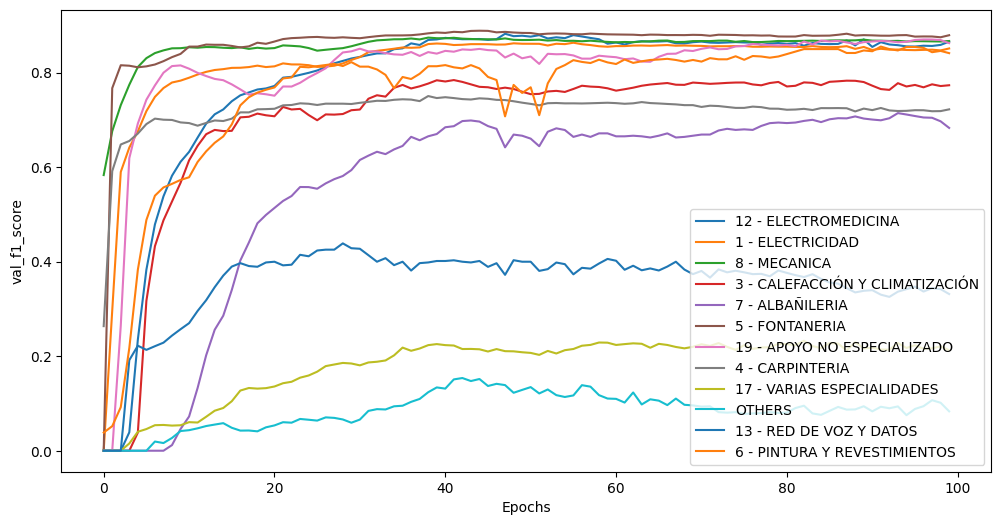

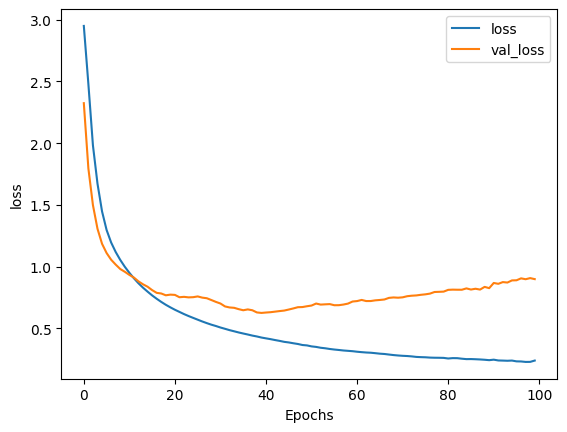

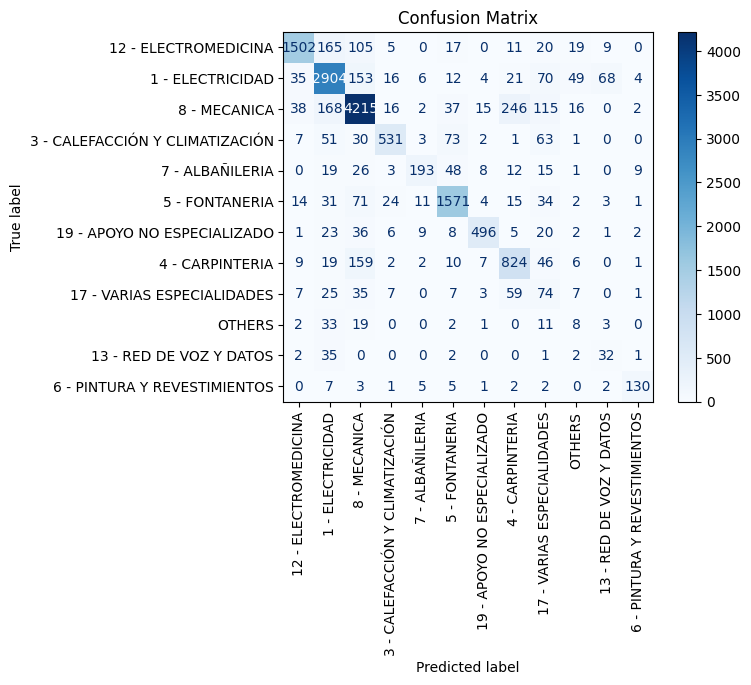

In [8]:
# Adding more activations nodes to the Dense layer
model_5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_5.summary()

model_5.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)
num_epochs = 100
history_5 = model_5.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    class_weight=class_weights,
    verbose=1
)

plot_validation_history(history_5, 'val_f1_score')
plot_training_history(history_5, 'loss')
plot_confusion_matrix(test_dataset, model_5)

Overfitting start to be more present when adding more neurons

Adding embedding dimensions

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 120, 16)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,708 (1.22 MB)

 Trainable params: 320,708 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.0568 - loss: 1.8892 - val_f1_score: 0.1006 - val_loss: 1.7238
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.1775 - loss: 1.4196 - val_f1_score: 0.2008 - val_loss: 1.1811
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2678 - loss: 1.0631 - val_f1_score: 0.2964 - val_loss: 0.9677
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.3219 - loss: 0.9068 - val_f1_score: 0.3493 - val_loss: 0.8577
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.3709 - loss: 0.8111 - val_f1_score: 0.4054 - val_loss: 0.7817
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4317 - loss: 0.7315 - val_f1_score: 0.4473 - val_loss: 0.7167
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4672 - loss: 0.6610 - val_f1_score: 0.4627 - val_loss: 0.6697
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4927 - loss: 0

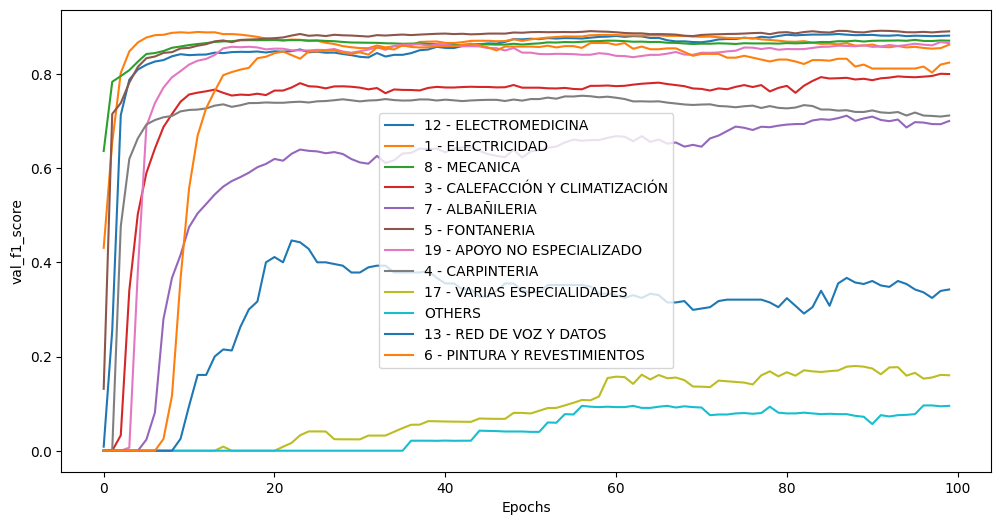

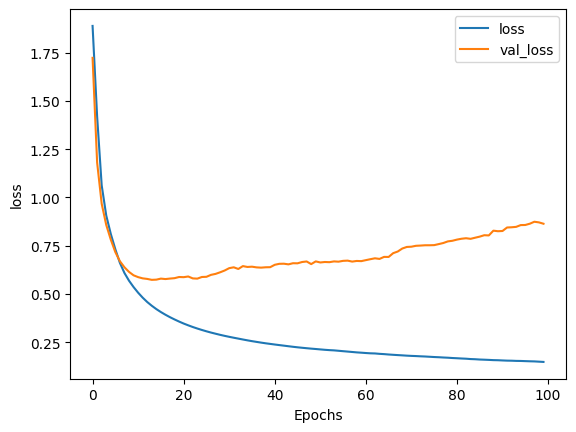

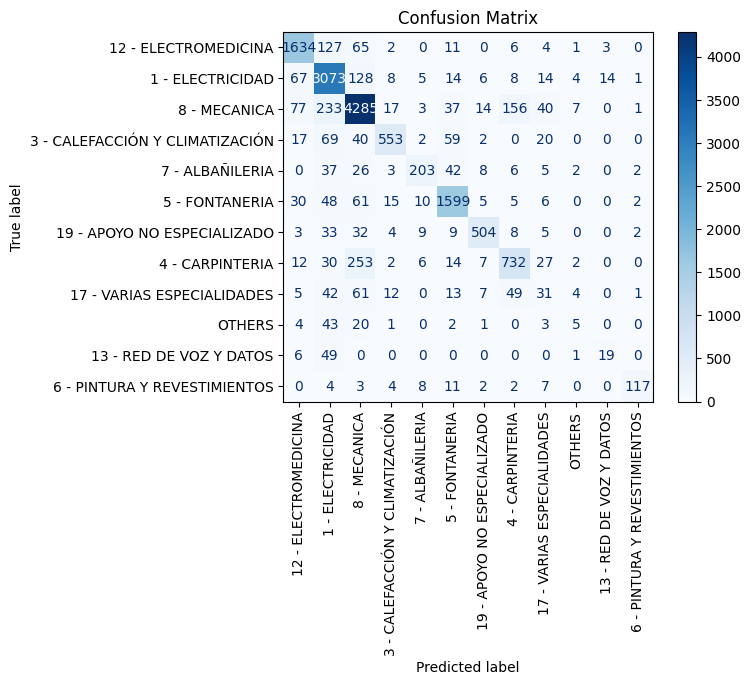

In [25]:
# Adding embedding dimensions
model_6 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_6.summary()

model_6.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)
num_epochs = 100
history_6 = model_6.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    # class_weight=class_weights,
    verbose=1
)

plot_validation_history(history_6, 'val_f1_score')
plot_training_history(history_6, 'loss')
plot_confusion_matrix(test_dataset, model_6)

With bigger embedding the system tend to overfitting too.

Adding a new Dense layer:

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,212 (942.23 KB)

 Trainable params: 241,212 (942.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.0404 - loss: 2.9612 - val_f1_score: 0.0683 - val_loss: 2.3339
Epoch 2/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.1600 - loss: 2.3903 - val_f1_score: 0.2599 - val_loss: 1.5832
Epoch 3/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.2750 - loss: 1.8375 - val_f1_score: 0.3335 - val_loss: 1.3563
Epoch 4/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3214 - loss: 1.5870 - val_f1_score: 0.3847 - val_loss: 1.2021
Epoch 5/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3526 - loss: 1.4270 - val_f1_score: 0.3990 - val_loss: 1.1205
Epoch 6/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3760 - loss: 1.2881 - val_f1_score: 0.4029 - val_loss: 1.0876
Epoch 7/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3947 - loss: 1.1814 - val_f1_score: 0.3940 - val_loss: 1.0702
Epoch 8/150
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4169 - loss: 1.1003 - val_

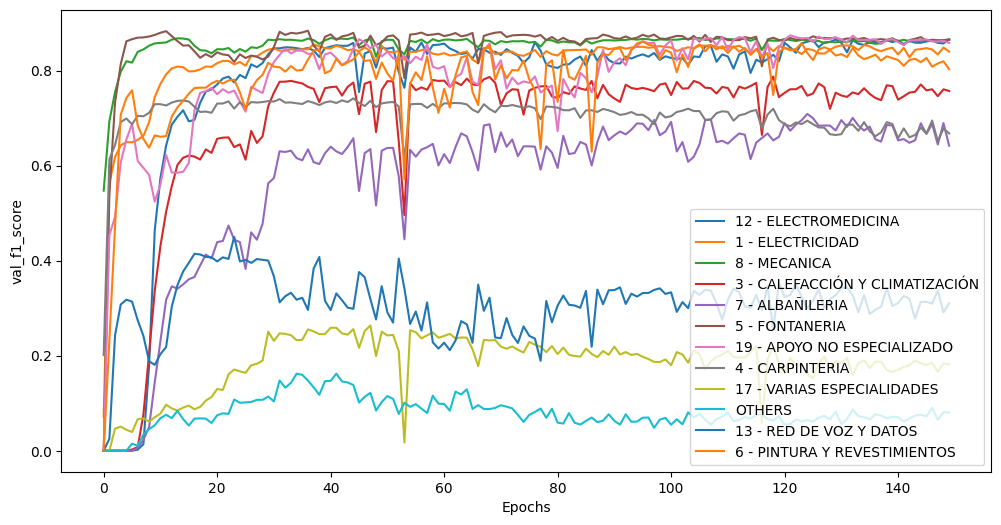

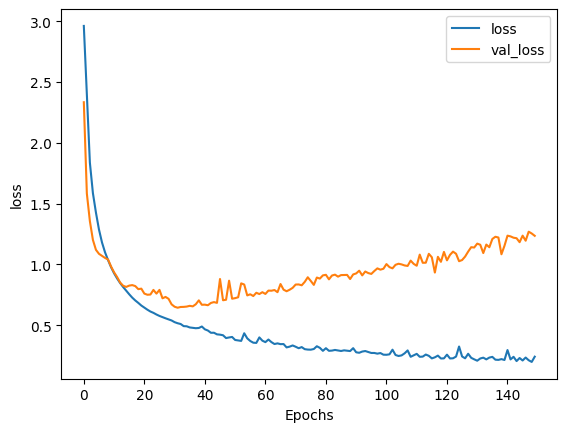

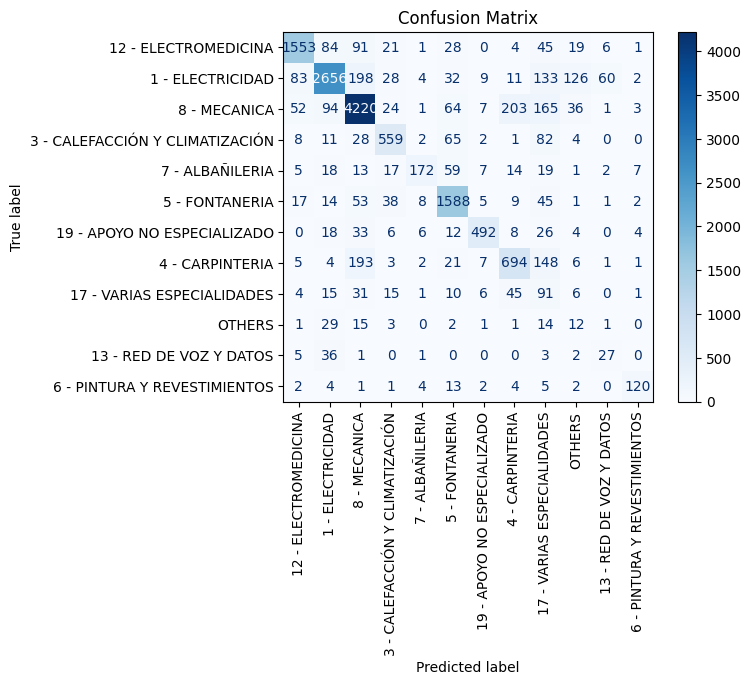

In [10]:
model_7 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(24, activation='relu'),  # Adding another Dense layer
    tf.keras.layers.Dense(12, activation='softmax')
])
model_7.summary()

model_7.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 150
history_7 = model_7.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    class_weight=class_weights,
    verbose=1
)

plot_validation_history(history_7, 'val_f1_score')
plot_training_history(history_7, 'loss')
plot_confusion_matrix(test_dataset, model_7)

Smaller Dense layer

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 12)             │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,312 (938.72 KB)

 Trainable params: 240,312 (938.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.0515 - loss: 1.9321 - val_f1_score: 0.0979 - val_loss: 1.8261
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.0996 - loss: 1.6425 - val_f1_score: 0.1053 - val_loss: 1.5056
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.1276 - loss: 1.3941 - val_f1_score: 0.1568 - val_loss: 1.3016
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.1793 - loss: 1.2066 - val_f1_score: 0.1938 - val_loss: 1.1430
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2317 - loss: 1.0821 - val_f1_score: 0.2592 - val_loss: 1.0530
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.3013 - loss: 0.9850 - val_f1_score: 0.2963 - val_loss: 0.9917
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.3502 - loss: 0.8996 - val_f1_score: 0.3171 - val_loss: 0.9544
Epoch 8/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.3904 - loss: 0

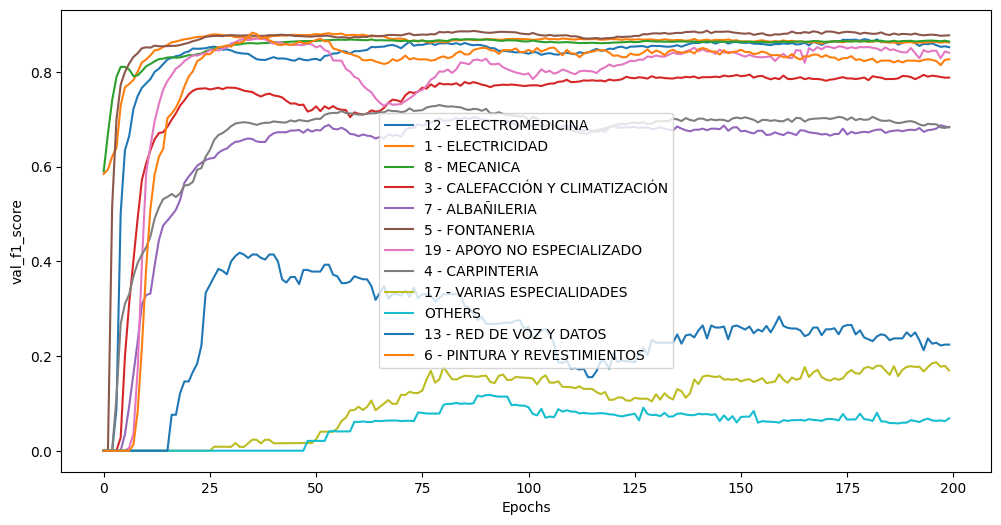

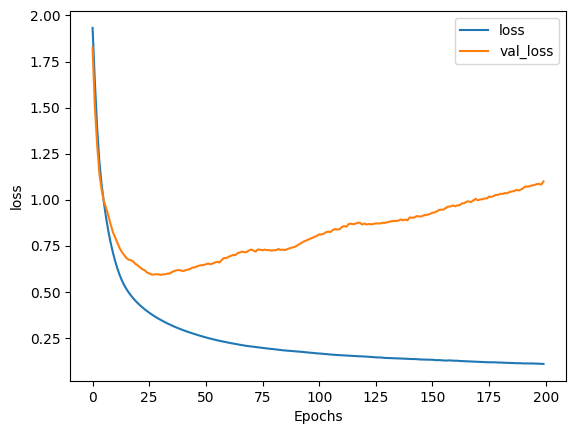

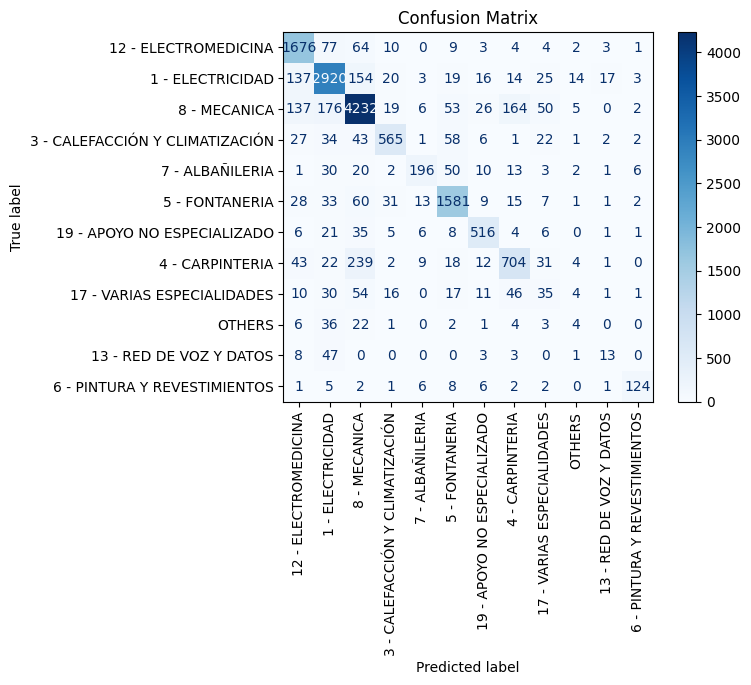

In [11]:
# Adding more activations nodes to the Dense layer
model_8 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_8.summary()

model_8.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)
num_epochs = 200
history_8 = model_8.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)

plot_validation_history(history_8, 'val_f1_score')
plot_training_history(history_8, 'loss')
plot_confusion_matrix(test_dataset, model_8)

Comparing the models performance

model_1: Validation F1 Score = 0.6755
model_2: Validation F1 Score = 0.6624
model_3: Validation F1 Score = 0.5850
model_4: Validation F1 Score = 0.6396
model_5: Validation F1 Score = 0.6645
model_6: Validation F1 Score = 0.6669
model_7: Validation F1 Score = 0.6446
model_8: Validation F1 Score = 0.6450


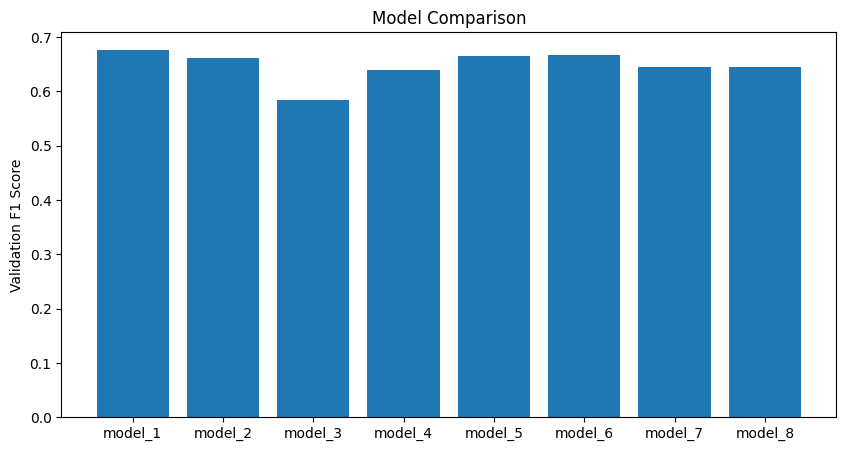

In [62]:
# Compare validation F1 scores for all models
histories = [
    history_1,  # model_1
    history_2,  # model_2
    history_3,  # model_3
    history_4,  # model_4
    history_5,  # model_5
    history_6,  # model_6
    history_7,  # model_7
    history_8,  # model_8
]

model_names = [f"model_{i+1}" for i in range(len(histories))]
val_f1_scores = [np.average(h.history['val_f1_score'][-1]) for h in histories]

scalar_f1_scores = []
for name, score in zip(model_names, val_f1_scores):
    # Convert TensorFlow tensor or numpy array to scalar float
    try:
        scalar_score = float(score.numpy().flatten()[0])
    except AttributeError:
        try:
            scalar_score = float(score.flatten()[0])
        except Exception:
            scalar_score = float(score)
    scalar_f1_scores.append(scalar_score)
    print(f"{name}: Validation F1 Score = {scalar_score:.4f}")

# Optionally, plot all validation F1 scores
plt.figure(figsize=(10,5))
plt.bar(model_names, scalar_f1_scores)
plt.ylabel('Validation F1 Score')
plt.title('Model Comparison')
plt.show()

Interestingly the best performance model is the first one, one of the most basic ones. Let's see if we can adjust some of the parameters of the model to outperform it.

Tweaking embedding dimensions

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 120, 8)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,516 (627.02 KB)

 Trainable params: 160,516 (627.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.0510 - loss: 1.9136 - val_f1_score: 0.0993 - val_loss: 1.7976
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.1269 - loss: 1.5482 - val_f1_score: 0.1652 - val_loss: 1.3254
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.2318 - loss: 1.1532 - val_f1_score: 0.2672 - val_loss: 1.0318
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.3178 - loss: 0.9545 - val_f1_score: 0.3874 - val_loss: 0.8952
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.4017 - loss: 0.8313 - val_f1_score: 0.4304 - val_loss: 0.7960
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.4379 - loss: 0.7391 - val_f1_score: 0.4576 - val_loss: 0.7228
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - f1_score: 0.4778 - loss: 0.6681 - val_f1_score: 0.4994 - val_loss: 0.6671
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - f1_score: 0.5266 - loss: 0

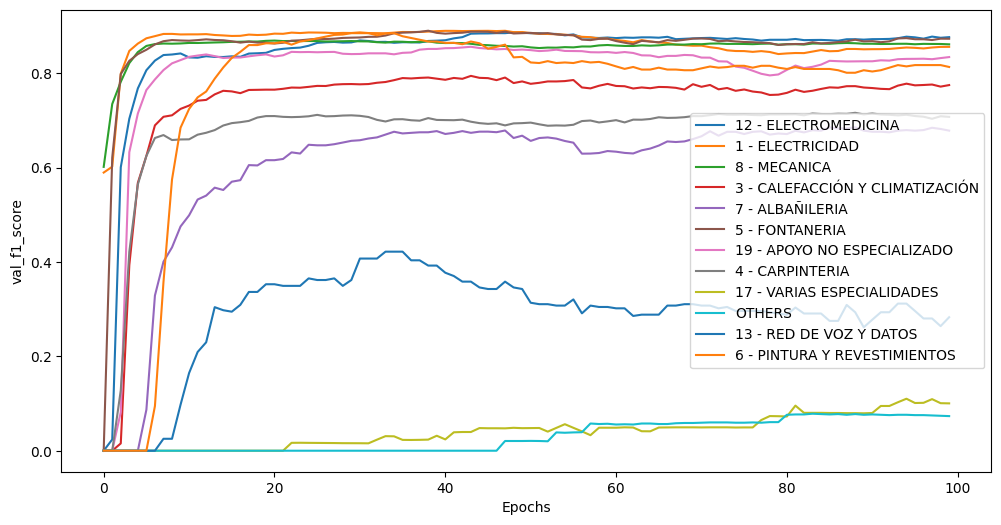

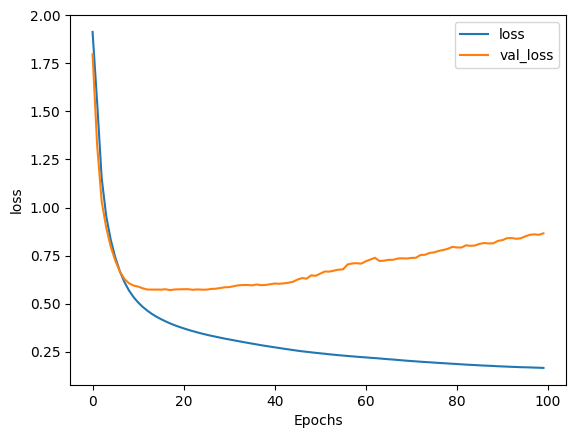

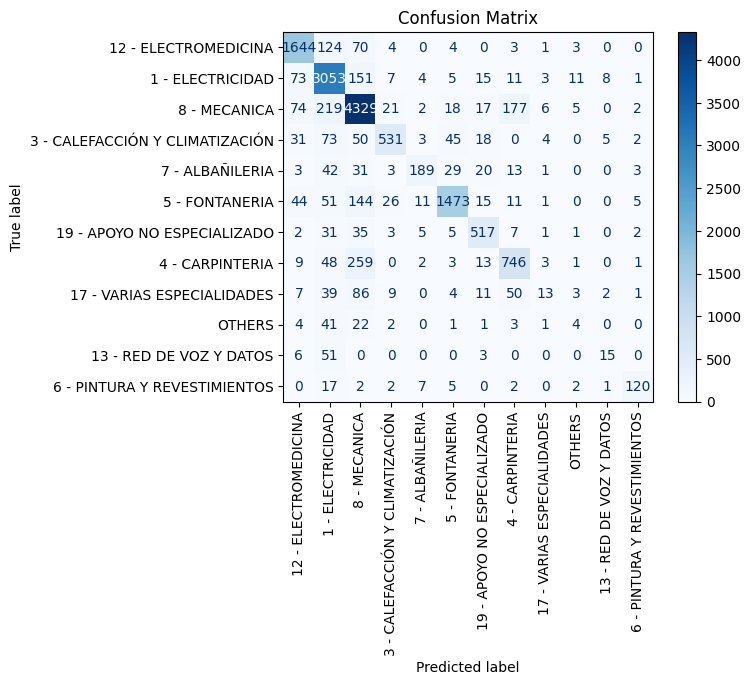

In [41]:
model_1_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=8), # Reduced embedding dimension
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_1_1.summary()

model_1_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 100
history_1_1 = model_1_1.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)

plot_validation_history(history_1_1, 'val_f1_score')
plot_training_history(history_1_1, 'loss')
plot_confusion_matrix(test_dataset, model_1_1)

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 120, 24)        │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120, 24)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_16     │ (None, 24)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 480,900 (1.83 MB)

 Trainable params: 480,900 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - f1_score: 0.0714 - loss: 1.8647 - val_f1_score: 0.1069 - val_loss: 1.6430
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.2062 - loss: 1.3481 - val_f1_score: 0.2694 - val_loss: 1.0857
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.3351 - loss: 0.9534 - val_f1_score: 0.3400 - val_loss: 0.8796
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.4162 - loss: 0.7793 - val_f1_score: 0.4149 - val_loss: 0.8085
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.4793 - loss: 0.6763 - val_f1_score: 0.4380 - val_loss: 0.7610
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.5120 - loss: 0.6045 - val_f1_score: 0.4743 - val_loss: 0.7047
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.5426 - loss: 0.5591 - val_f1_score: 0.4998 - val_loss: 0.7009
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - f1_score: 0.5803 - loss: 0

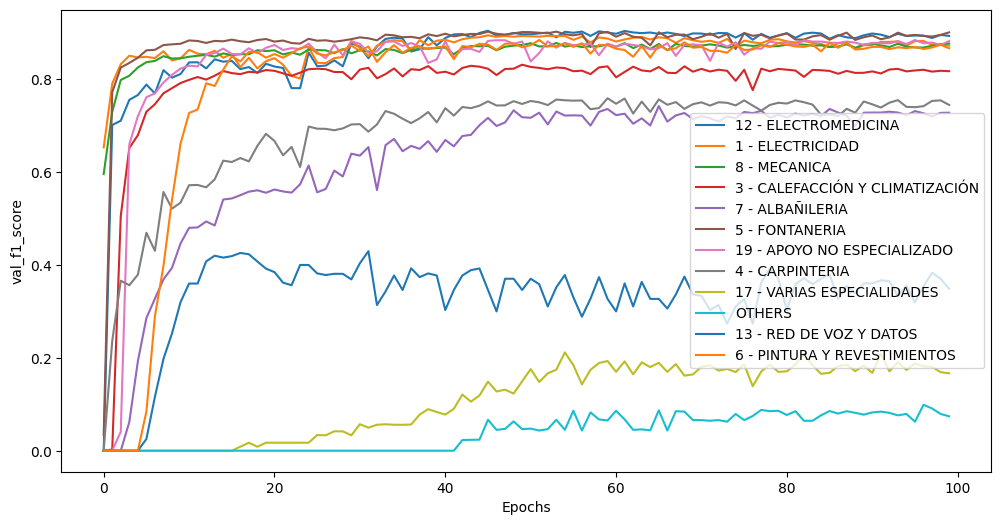

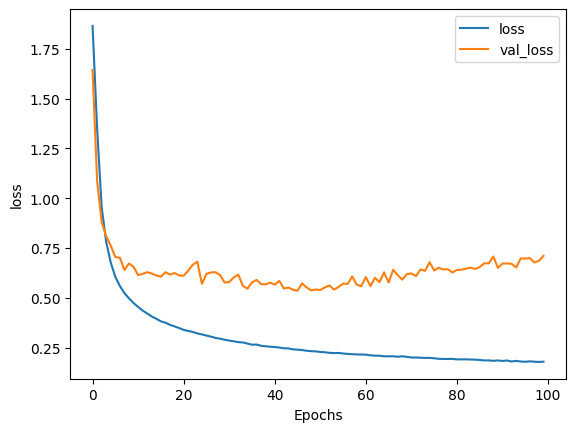

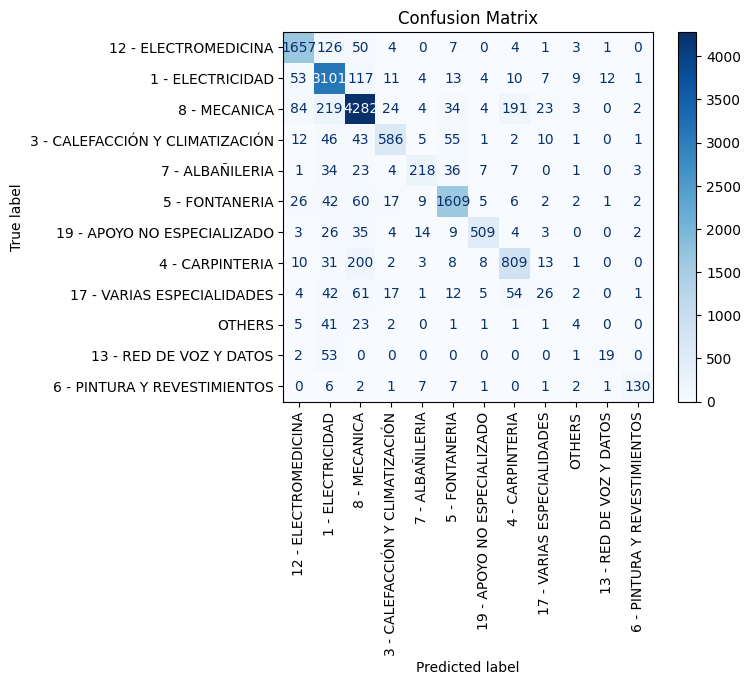

In [42]:
model_1_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=24), # Increased embedding dimension
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_1_2.summary()

model_1_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 100
history_1_2 = model_1_2.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)

plot_validation_history(history_1_2, 'val_f1_score')
plot_training_history(history_1_2, 'loss')
plot_confusion_matrix(test_dataset, model_1_2)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)        │ (None, 120, 36)        │       720,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 120, 36)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_18     │ (None, 36)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 24)             │           888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 721,188 (2.75 MB)

 Trainable params: 721,188 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - f1_score: 0.0759 - loss: 1.8428 - val_f1_score: 0.1096 - val_loss: 1.5915
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.2186 - loss: 1.2767 - val_f1_score: 0.2616 - val_loss: 1.0417
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.3638 - loss: 0.9123 - val_f1_score: 0.3873 - val_loss: 0.8331
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.4265 - loss: 0.7590 - val_f1_score: 0.4231 - val_loss: 0.7468
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.4703 - loss: 0.6646 - val_f1_score: 0.4926 - val_loss: 0.6747
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.5384 - loss: 0.5927 - val_f1_score: 0.5368 - val_loss: 0.6260
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.5791 - loss: 0.5447 - val_f1_score: 0.5578 - val_loss: 0.6299
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - f1_score: 0.6169 - loss: 

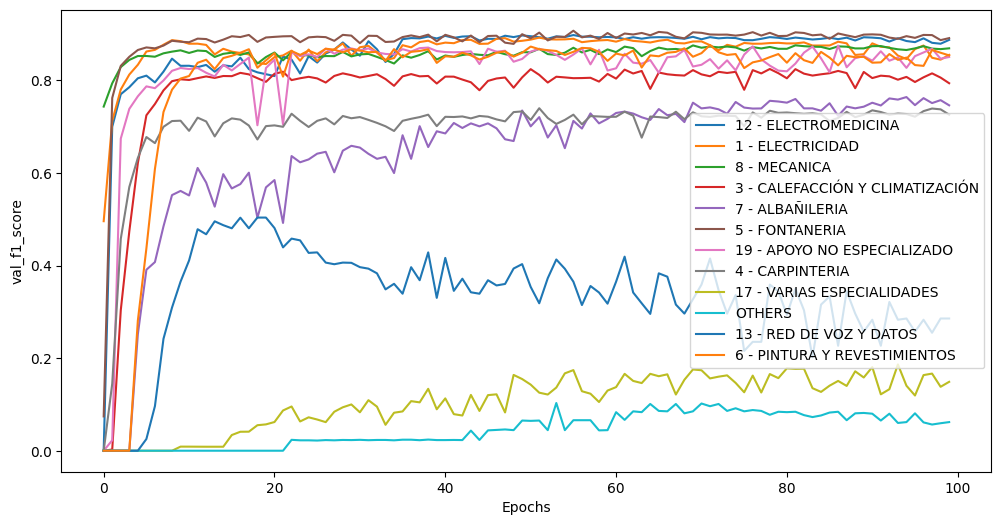

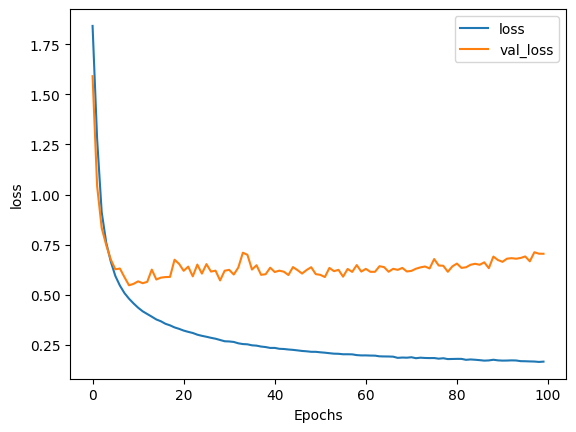

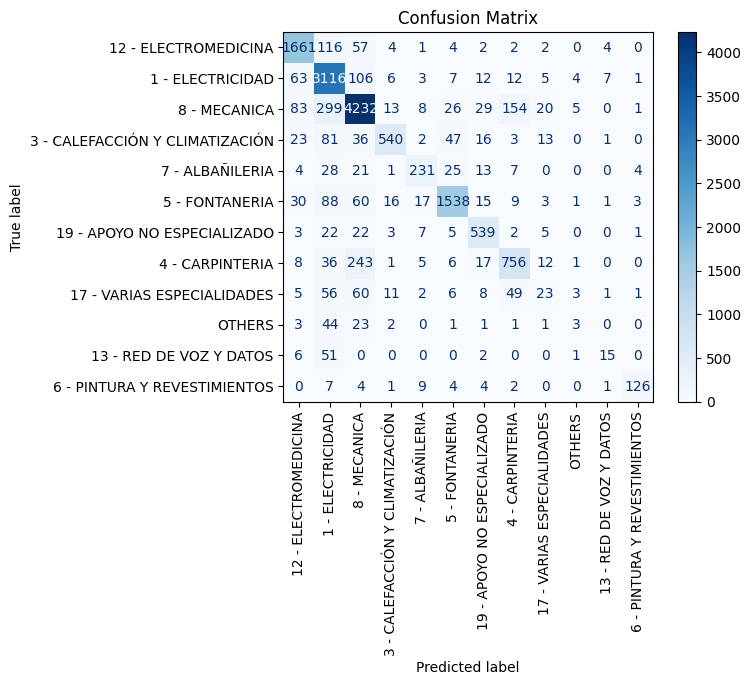

In [44]:
model_1_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=36), # Increased embedding dimension
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_1_3.summary()

model_1_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 100
history_1_3 = model_1_3.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)

plot_validation_history(history_1_3, 'val_f1_score')
plot_training_history(history_1_3, 'loss')
plot_confusion_matrix(test_dataset, model_1_3)

Lets train the best model for longer to see if it improves.

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_23 (Embedding)        │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 120, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_19     │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,612 (939.89 KB)

 Trainable params: 240,612 (939.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - f1_score: 0.0417 - loss: 1.9286 - val_f1_score: 0.0478 - val_loss: 1.8754
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.1285 - loss: 1.6414 - val_f1_score: 0.1713 - val_loss: 1.3825
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.2174 - loss: 1.2340 - val_f1_score: 0.2765 - val_loss: 1.0783
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.3206 - loss: 0.9914 - val_f1_score: 0.3533 - val_loss: 0.8923
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.4068 - loss: 0.8428 - val_f1_score: 0.4114 - val_loss: 0.7796
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.4644 - loss: 0.7397 - val_f1_score: 0.4583 - val_loss: 0.7101
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.5139 - loss: 0.6696 - val_f1_score: 0.5103 - val_loss: 0.6668
Epoch 8/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.5574 - loss: 0.6191 - val_

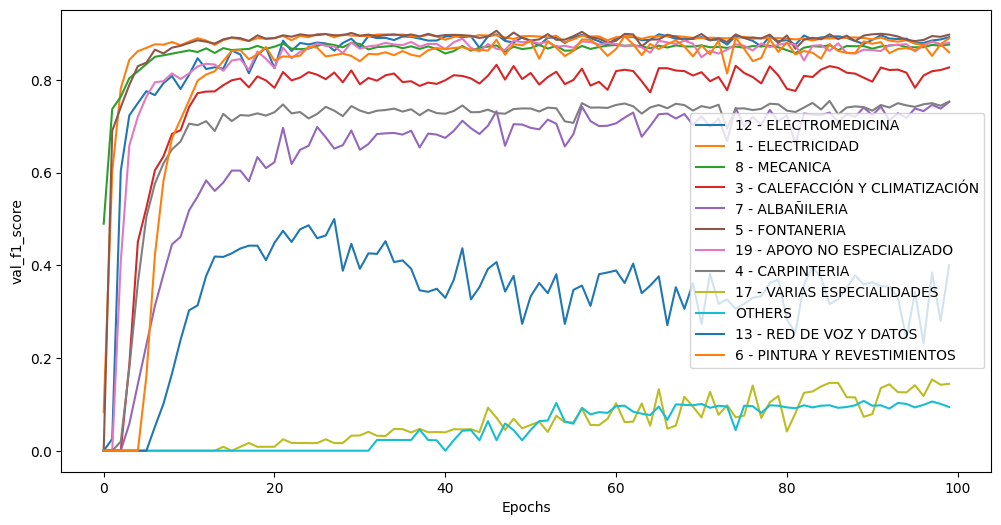

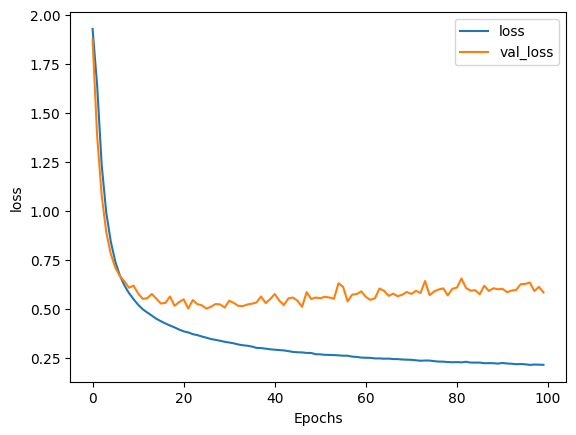

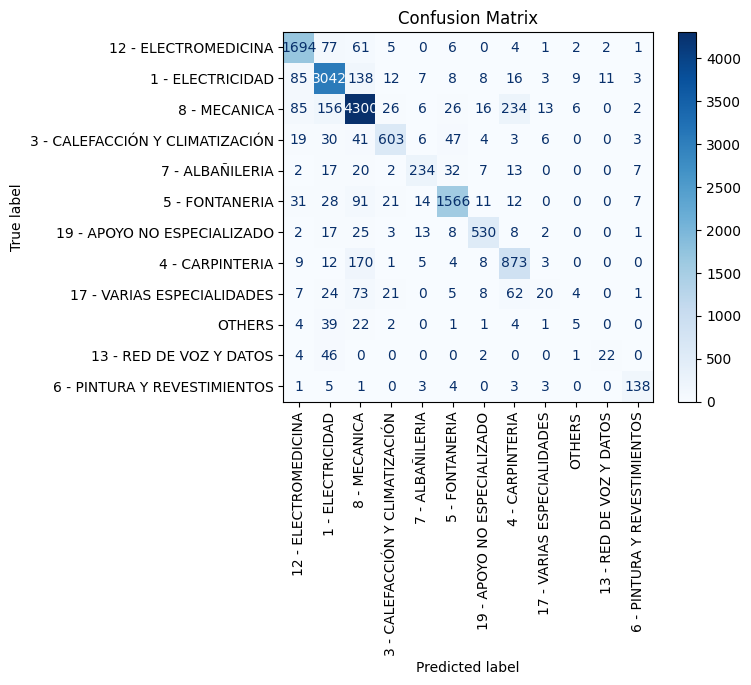

In [45]:
model_1_4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_1_4.summary()

model_1_4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 100
history_1_4 = model_1_4.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)

plot_validation_history(history_1_4, 'val_f1_score')
plot_training_history(history_1_4, 'loss')
plot_confusion_matrix(test_dataset, model_1_4)

model_1_0: Validation F1 Score = 0.6755
model_1_1: Validation F1 Score = 0.6445
model_1_2: Validation F1 Score = 0.6810
model_1_3: Validation F1 Score = 0.6644
model_1_4: Validation F1 Score = 0.6891


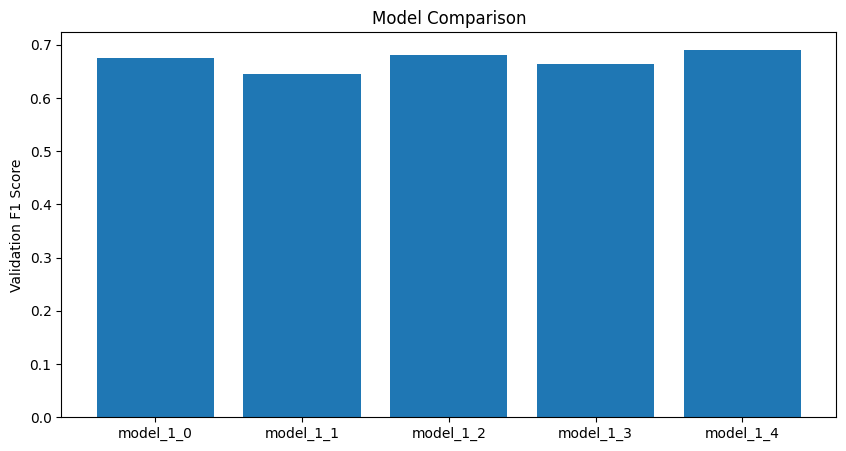

In [61]:
# Compare validation F1 scores for all models
histories = [
    history_1,  # model_1
    history_1_1,  # model_1_1
    history_1_2,  # model_1_2
    history_1_3,  # model_1_3
    history_1_4,  # model_1_4
]

model_names = [f"model_1_{i}" for i in range(len(histories))]
val_f1_scores = [np.average(h.history['val_f1_score'][-1]) for h in histories]

scalar_f1_scores = []
for name, score in zip(model_names, val_f1_scores):
    # Convert TensorFlow tensor or numpy array to scalar float
    try:
        scalar_score = float(score.numpy().flatten()[0])
    except AttributeError:
        try:
            scalar_score = float(score.flatten()[0])
        except Exception:
            scalar_score = float(score)
    scalar_f1_scores.append(scalar_score)
    print(f"{name}: Validation F1 Score = {scalar_score:.4f}")

# Optionally, plot all validation F1 scores
plt.figure(figsize=(10,5))
plt.bar(model_names, scalar_f1_scores)
plt.ylabel('Validation F1 Score')
plt.title('Model Comparison')
plt.show()

Running the best overall model_1_4 longer to observe any posible improvement.

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 120, 12)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 120, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_20     │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,612 (939.89 KB)

 Trainable params: 240,612 (939.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - f1_score: 0.0719 - loss: 1.8597 - val_f1_score: 0.1030 - val_loss: 1.6428
Epoch 2/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.1481 - loss: 1.4651 - val_f1_score: 0.2067 - val_loss: 1.2691
Epoch 3/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.2329 - loss: 1.1715 - val_f1_score: 0.2487 - val_loss: 1.0800
Epoch 4/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.2879 - loss: 1.0072 - val_f1_score: 0.2981 - val_loss: 0.9814
Epoch 5/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.3498 - loss: 0.8840 - val_f1_score: 0.3560 - val_loss: 0.8490
Epoch 6/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.4077 - loss: 0.7898 - val_f1_score: 0.4298 - val_loss: 0.7693
Epoch 7/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - f1_score: 0.4510 - loss: 0.7080 - val_f1_score: 0.4602 - val_loss: 0.7207
Epoch 8/200
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - f1_score: 0.4874 - loss: 0

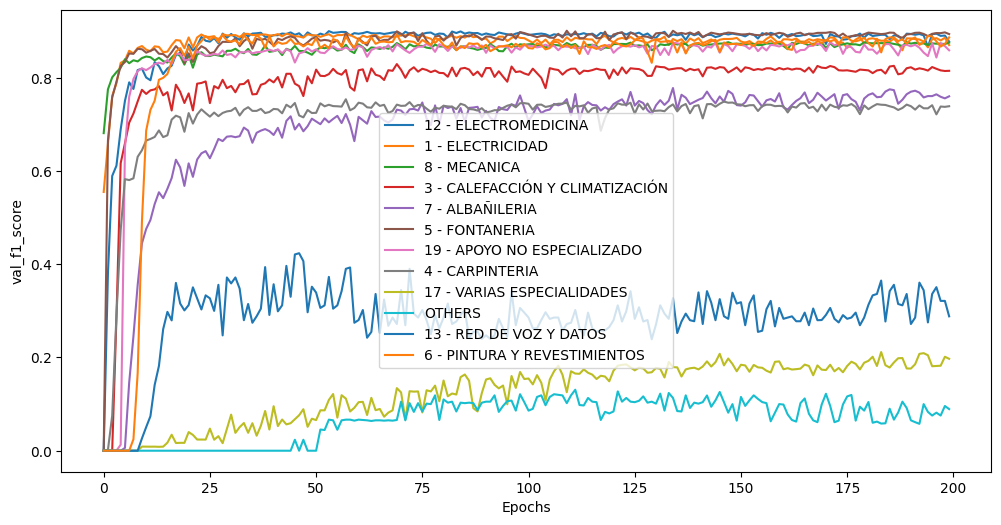

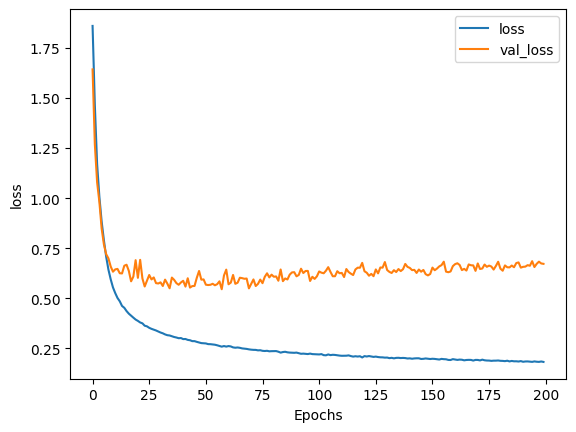

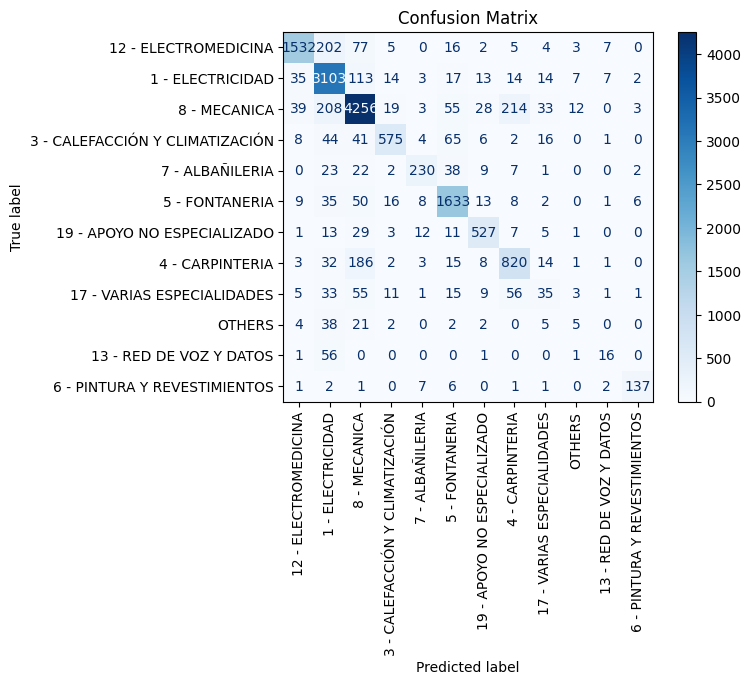

In [48]:
model_1_4_ext = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(120,)),
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=12),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model_1_4_ext.summary()

model_1_4_ext.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.F1Score(),
    ]
)

num_epochs = 200
history_1_4_ext = model_1_4_ext.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset,
    verbose=1
)

plot_validation_history(history_1_4_ext, 'val_f1_score')
plot_training_history(history_1_4_ext, 'loss')
plot_confusion_matrix(test_dataset, model_1_4_ext)

In [60]:
# Calculate the average of the validation F1 scores
val_f1_average = np.average(history_1_4_ext.history['val_f1_score'][-1])
print(f"Average Validation F1 Score: {val_f1_average:.4f}")

Average Validation F1 Score: 0.6794


To choose the best model among the 10 candidates, compare their validation F1 scores and losses. The model with the highest validation F1 score and lowest validation loss is generally preferred, but also consider overfitting and performance on minority classes. Visualize the metrics for all models to make an informed decision.

The best overall performance model correspond to the model_1_4. Has the best accuracy around the small labels. It's so notable how well the model predicts the labels with more than 1500 entries and in the other hand, how hard is to predict the last 4 appearing labels (with the exception of "6 - PINTURA Y REVESTIMIENTOS"). This is due to the lack of entries for those labels but also for the ambiguity of the content. For example, the decision of grouping the labels with less than 300 entries in "OTHERS" makes hard for the model to find a pattern for those unrelated entries. That also happen natively with "17 - VARIAS ESPECIALIDADES" witch is a label use often when is not clear for whom the ticket should go. Finalmente "13 - RED DE VOZ Y DATOS" is technically closely related with "1 - ELECTRICIDAD", and that can be probe for the confusion matrix, where the true labels where confused for the mentioned label most of the time. 

| Especialidad_groped                | Count  |
|------------------------------------|--------|
| 8 - MECANICA                       | 24477  |
| 1 - ELECTRICIDAD                   | 16674  |
| 12 - ELECTROMEDICINA               | 9048   |
| 5 - FONTANERIA                     | 8910   |
| 4 - CARPINTERIA                    | 5318   |
| 3 - CALEFACCIÓN Y CLIMATIZACIÓN    | 3801   |
| 19 - APOYO NO ESPECIALIZADO        | 3089   |
| 7 - ALBAÑILERIA                    | 1704   |
| 17 - VARIAS ESPECIALIDADES         | 1140   |
| 6 - PINTURA Y REVESTIMIENTOS       | 891    |
| OTHERS                             | 435    |
| 13 - RED DE VOZ Y DATOS            | 379    |

In [ ]:
# Save the best performance model
current_dir = os.getcwd()
model_1_4_ext.save(os.path.join(current_dir, '..', 'model', 'best_model.keras'))

### 4. Results

It's interesting to see how in this case, in the text analyzed in this case of NLP the relation withing words (RNN) it's not relevant for the creation of the model. The poor performance of the LSTM compere to the regular DNN proves the affirmation.

### 5. Challenges

### 6. Next Steps

The final stage is to evaluate the model with new open tickets and check how performs compare to the labels the users choose. 